In [1]:
import os 

#sys.path.insert(0,"/homes/o23gauvr/Documents/thèse/code/FASCINATION/")
running_path = "/Odyssey/private/o23gauvr/code/FASCINATION/"
os.chdir(running_path)

In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import hydra
import pickle
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import math
#import cartopy.crs as ccrs


import src.differentiable_fonc as DF

from src.utils import *


In [3]:
plt.style.use('ggplot')

In [4]:
cmap = plt.get_cmap('viridis')

In [5]:
gpu = 0
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [6]:
load_pca = True

if load_pca:
    with open("pickle/trained_pca_on_dm_3D_norm_False.pkl", "rb") as file:
        pca_dict = pickle.load(file)   
else:
    pca_dict = {}

/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.4.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
try:
    if dm_dict:
        print("Not reloading datamodule")

except:
    
    dm_dict = {}
    n_components = 0
    print("Initializing datamodule")

Initializing datamodule


# Useful functions

In [8]:


class NoConvAE(nn.Module):
    def __init__(self, 
                 n:int, 
                 pooling_dim:str = "spatial",
                 pooling_mode:str = "Avg"):


        super().__init__()

        self.upsample_mode = "trilinear"


        if pooling_dim == "all":
            pool_str = 2
            
        elif pooling_dim == "depth":
            pool_str = (2,1,1)

        elif pooling_dim == "spatial":
            pool_str = (1,2,2)
        
        elif pooling_dim == None:
            pool_str = 1




        pooling_dict = {"Avg": nn.AvgPool3d(kernel_size= 1,stride=pool_str, padding = 0),
                        "Max": nn.MaxPool3d(kernel_size=1, stride=pool_str, padding = 0),
                        "None": nn.Identity()}     
        
        upsample_dict = {"Avg": nn.Upsample(scale_factor = pool_str, mode = self.upsample_mode),
                        "Max":  nn.Upsample(scale_factor = pool_str, mode = self.upsample_mode),
                        "None": nn.Identity()}   
        
        pool_layer = pooling_dict[pooling_mode]
        upsample_layer = upsample_dict[pooling_mode]

            

        self.encoder = nn.Sequential(*[pool_layer for i in range(n)])
    
        self.decoder = nn.Sequential(*[upsample_layer for i in range(n-1)])

        self.decoder.append(nn.Upsample(size=None, mode=self.upsample_mode))

    
    def forward(self,x):

        self.decoder[-1].size = x.shape[-3:]

        x = x.unsqueeze(1)

        self.bottleneck = self.encoder(x)

        self.bottleneck_shape = self.bottleneck.shape

        self.output = self.decoder(self.bottleneck).squeeze(1)
    

        return self.output



In [9]:

def plot_unorm_ssp_2D(unorm_test_truth_ssp_arr,
                      unorm_test_pca_ssp_arr,
                      unorm_test_ae_ssp_arr, 
                      dm,
                      bottleneck_shape_tuple,
                      t,
                      lat):
    
    
    depth_array = dm.depth_array
    coords = dm.test_data_da.coords
    
    unorm_test_truth_ssp_arr_2D = unorm_test_truth_ssp_arr[t,:,lat,:]
    unorm_test_ae_ssp_arr_2D = unorm_test_ae_ssp_arr[t,:,lat,:]
    unorm_test_pca_ssp_arr_2D = unorm_test_pca_ssp_arr[t,:,lat,:]
    
    
    fig,axs = plt.subplots(1,3,figsize=(25,6), gridspec_kw={'width_ratios': [1, 1, 1]})

    im1 = axs[0].imshow(unorm_test_truth_ssp_arr_2D, cmap=cmap, aspect = "equal")  
    im2 = axs[1].imshow(unorm_test_pca_ssp_arr_2D, cmap=cmap, aspect = "equal")
    im3 = axs[2].imshow(unorm_test_ae_ssp_arr_2D, cmap=cmap, aspect = "equal")
    
    

    ecs_truth_idx_2D = np.argmax(unorm_test_truth_ssp_arr_2D,axis=0)
    ecs_truth_2D = depth_array[ecs_truth_idx_2D]
    
    ecs_pca_idx_2D = np.argmax(unorm_test_pca_ssp_arr_2D,axis=0)
    ecs_pca_2D = depth_array[ecs_pca_idx_2D]
    
    ecs_ae_idx_2D = np.argmax(unorm_test_ae_ssp_arr_2D,axis=0)
    ecs_ae_2D = depth_array[ecs_ae_idx_2D]

    axs[0].plot(ecs_truth_idx_2D, label = "ECS")
    axs[1].plot(ecs_pca_idx_2D, label = f"ECS RMSE={np.sqrt(np.mean((ecs_truth_2D-ecs_pca_2D)**2)):.2f}m")
    axs[2].plot(ecs_ae_idx_2D, label = f"ECS RMSE ={np.sqrt(np.mean((ecs_truth_2D-ecs_ae_2D)**2)):.2f}m")
    
    


    y_tick_indices = np.linspace(0, len(depth_array) - 1, 5, dtype=int)
    y_tick_values = depth_array[y_tick_indices]

    x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
    x_tick_values = coords["lon"].data[x_tick_indices]
    
    
    
    
    for ax in axs[:]:

        ax.set_yticks(y_tick_indices)
        ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
        
        ax.set_xticks(x_tick_indices)
        ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
        ax.grid(False)
        
        ax.set_xlabel("Longitude (°)")
        ax.legend(loc = "lower left")
        

    ae_bottleneck_shape, pca_bottleneck_shape = bottleneck_shape_tuple
    compression_rate_pca = np.prod(dm.test_shape)/np.prod(pca_bottleneck_shape)
    compression_rate_ae = np.prod(dm.test_shape)/np.prod(ae_bottleneck_shape)

    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"PCA reconstruction\nbottleneck shape:{list(pca_bottleneck_shape)}, compression rate: {np.round(compression_rate_pca,2)} \nRMSE={np.sqrt(np.mean((unorm_test_truth_ssp_arr_2D-unorm_test_pca_ssp_arr_2D)**2)):.8f}m", fontsize = 10) #/np.sum(ssp_truth_unorm_test_arr**2))*100
    axs[2].set_title(f"AE reconstruction\nbottleneck shape:{list(ae_bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)} \nRMSE={np.sqrt(np.mean((unorm_test_truth_ssp_arr_2D-unorm_test_ae_ssp_arr_2D)**2)):.8f}m", fontsize = 10) #/np.sum(ssp_truth_unorm_test_arr**2))*100

    axs[0].set_ylabel('Depth (m)')


    cbar = fig.colorbar(im3, ax=axs.ravel().tolist(), shrink = 0.5, aspect=12, pad = 0.02)
    cbar.set_label("m/s")

    min_val, max_val = im3.get_clim()
    ticks = np.linspace(min_val, max_val, 4)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

    #fig.tight_layout()
    fig.suptitle(f"Sound Speed reconstruction \n date: {coords['time'].data[t].astype('datetime64[D]')}, lat: {np.round(dm.coords['lat'].data[lat],2)}", x=0.45, y=0.85)
    
    


In [10]:
def plot_norm_ssp_2D(norm_test_truth_ssp_arr,
                     norm_test_ae_ssp_arr, 
                     dm,
                     ae_bottleneck_shape,
                     t,
                     lat):
    
    
    coords = dm.test_data_da.coords
    
    
    norm_test_truth_ssp_arr_2D = norm_test_truth_ssp_arr[t,:,lat,:]
    norm_test_ae_ssp_arr_2D = norm_test_ae_ssp_arr[t,:,lat,:]
    
    
    fig,axs = plt.subplots(1,2,figsize=(19,7), gridspec_kw={'width_ratios': [1, 1]})

    im1 = axs[0].imshow(norm_test_truth_ssp_arr_2D, cmap=cmap, aspect = "equal")  
    im2 = axs[1].imshow(norm_test_ae_ssp_arr_2D, cmap=cmap, aspect = "equal")
    
    

    # ecs_truth_idx_2D = np.argmax(norm_test_truth_ssp_arr_2D,axis=0)
    # ecs_truth_2D = depth_array[ecs_truth_idx_2D]
    
    # ecs_ae_idx_2D = np.argmax(norm_test_ae_ssp_arr_2D,axis=0)
    # ecs_ae_2D = depth_array[ecs_truth_idx_2D]

    # axs[0].plot(ecs_truth_idx_2D, label = "ECS")
    # axs[1].plot(ecs_ae_idx_2D, label = f"ECS RMSE ={np.sqrt(np.mean((ecs_truth_2D-ecs_ae_2D)**2)):.2f}m")
    
    


    y_tick_indices = np.linspace(0, len(coords["z"].data) - 1, 5, dtype=int)
    y_tick_values = coords["z"].data[y_tick_indices]

    x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
    x_tick_values = coords["lon"].data[x_tick_indices]
    
    
    
    
    for ax in axs[:]:
        
        ax.set_yticks(y_tick_indices)
        ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
        
        ax.set_xticks(x_tick_indices)
        ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
        ax.grid(False)
        
        ax.set_xlabel("Longitude (°)")


    compression_rate_ae = np.prod(dm.test_shape)/np.prod(ae_bottleneck_shape)

    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"AE reconstruction\nbottleneck shape:{list(ae_bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)} \nRMSE={np.sqrt(np.mean((norm_test_truth_ssp_arr_2D-norm_test_ae_ssp_arr_2D)**2)):.8f}", fontsize = 10) #/np.sum(ssp_truth_norm_test_arr**2))*100

    axs[0].set_ylabel('z')


    cbar = fig.colorbar(im2, ax=axs.ravel().tolist(), shrink = 0.5, aspect=12, pad = 0.02)
    cbar.set_label("normalized")

    min_val, max_val = im2.get_clim()
    ticks = np.linspace(min_val, max_val, 4)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

    #fig.tight_layout()

    fig.suptitle(f"Normalized Sound Speed reconstruction\n date:{coords['time'].data[t].astype('datetime64[D]')}, lat:{np.round(dm.coords['lat'].data[lat],2)}",x = 0.45, y = 0.80)
    
    


In [11]:
def plot_imgs_depth_lon_filtered_2D(ssp_truth_unorm_test_arr,
                                    ssp_ae_unorm_test_arr,  
                                    ssp_3D_median,
                                    ecs_truth,
                                    ecs_pred_ae,
                                    ecs_pred_ae_median,
                                    depth_array,
                                    coords,
                                    compression_rate_ae, 
                                    bottleneck_shape,
                                    median_kernel):
    
    fig,axs = plt.subplots(1,3,figsize=(25,6), gridspec_kw={'width_ratios': [1, 1, 1]})

    im1 = axs[0].imshow(ssp_truth_unorm_test_arr, cmap=cmap, aspect = "equal")  
    im2 = axs[1].imshow(ssp_ae_unorm_test_arr, cmap=cmap, aspect = "equal")
    im3 = axs[2].imshow(ssp_3D_median, cmap=cmap, aspect = "equal")


    y_tick_indices = np.linspace(0, len(depth_array) - 1, 5, dtype=int)
    y_tick_values = depth_array[y_tick_indices]

    x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
    x_tick_values = coords["lon"].data[x_tick_indices]
    

    indices_ecs_truth = np.searchsorted(depth_array, ecs_truth.detach().cpu().numpy())
    indices_ecs_ae = np.searchsorted(depth_array, ecs_pred_ae.detach().cpu().numpy())
    indices_ecs_ae_median  = np.searchsorted(depth_array, ecs_pred_ae_median.flatten().detach().cpu().numpy())


    axs[0].plot(indices_ecs_truth, label = "ECS")
    axs[1].plot(indices_ecs_ae, label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth-ecs_pred_ae)**2)).item(),2)}m")
    axs[2].plot(indices_ecs_ae_median, label = f"ECS RMSE ={np.round(torch.sqrt(torch.mean((ecs_truth-ecs_pred_ae_median)**2)).item(),2)}m")


    for ax in axs[:]:
        ax.set_yticks(y_tick_indices)
        ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
        
        ax.set_xticks(x_tick_indices)
        ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
        ax.grid(False)
        
        ax.set_xlabel("Longitude (°)")
        ax.legend(loc = "lower left")
        
        #ax.invert_yaxis() 

    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"AE reconstruction\n \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr-ssp_ae_unorm_test_arr)**2)),8)}m", fontsize = 10) #/np.sum(ssp_truth_unorm_test_arr**2))*100
    axs[2].set_title(f"AE filtered reconstruction\n median filter kernel size: {median_kernel} \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr-ssp_3D_median)**2)),8)}m", fontsize = 10) #/np.sum(ssp_truth_unorm_test_arr**2))*100

    axs[0].set_ylabel('Depth (m)')


    cbar = fig.colorbar(im3, ax=axs.ravel().tolist(), shrink = 0.5, aspect=12, pad = 0.02)
    cbar.set_label("m/s")

    min_val, max_val = im3.get_clim()
    ticks = np.linspace(min_val, max_val, 4)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

    #fig.tight_layout()

    fig.suptitle(f"Sound Speed reconstruction\nbottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)}",x = 0.45, y = 0.85)


In [12]:

def plot_unorm_ssp_profiles(unorm_test_truth_ssp_arr,
                            unorm_test_pca_ssp_arr,
                            unorm_test_ae_ssp_arr, 
                            dm,
                            bottleneck_shape_tuple,
                            t,
                            lat,
                            lon):
    
    
    depth_array = dm.depth_array
    coords = dm.test_data_da.coords
    

    
    unorm_test_truth_ssp_arr_profile = unorm_test_truth_ssp_arr[t,:,lat,lon]
    unorm_test_ae_ssp_arr_profile = unorm_test_ae_ssp_arr[t,:,lat,lon]
    unorm_test_pca_ssp_arr_profile = unorm_test_pca_ssp_arr[t,:,lat,lon]
    
    
    fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})

    axs[0].plot(unorm_test_truth_ssp_arr_profile, depth_array, c = "navy")  
    axs[1].plot(unorm_test_pca_ssp_arr_profile, depth_array, c="navy")
    axs[2].plot(unorm_test_ae_ssp_arr_profile, depth_array, c ="navy")


    ecs_truth_idx = np.argmax(unorm_test_truth_ssp_arr_profile,axis=0)
    ecs_truth = depth_array[ecs_truth_idx]
    
    ecs_pca_idx = np.argmax(unorm_test_pca_ssp_arr_profile,axis=0)
    ecs_pca = depth_array[ecs_pca_idx]
    
    ecs_ae_idx = np.argmax(unorm_test_ae_ssp_arr_profile,axis=0)
    ecs_ae = depth_array[ecs_ae_idx]


    xmin, xmax = axs[0].get_xlim()
    axs[0].hlines(ecs_truth, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth)}m", colors = "coral")
    
    xmin, xmax = axs[1].get_xlim()
    axs[1].hlines(ecs_pca, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pca)}m", colors = "coral")

    xmin, xmax = axs[2].get_xlim()
    axs[2].hlines(ecs_ae, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_ae)}m", colors = "coral")




    for ax in axs[:]:

        ax.legend(loc = "lower right")
        ax.set_xlabel("Sound Speed (°)")
        
        ax.invert_yaxis() 
        

    ae_bottleneck_shape, pca_bottleneck_shape = bottleneck_shape_tuple
    compression_rate_pca = np.prod(dm.test_shape)/np.prod(pca_bottleneck_shape)
    compression_rate_ae = np.prod(dm.test_shape)/np.prod(ae_bottleneck_shape)
    
    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"PCA reconstruction\nbottleneck shape:{list(pca_bottleneck_shape)}, compression rate: {np.round(compression_rate_pca,2)} \nRMSE={np.sqrt(np.mean((unorm_test_truth_ssp_arr_profile-unorm_test_pca_ssp_arr_profile)**2)):.8f}m", fontsize = 10)
    axs[2].set_title(f"AE reconstruction\nbottleneck shape:{list(ae_bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)} \nRMSE={np.sqrt(np.mean((unorm_test_truth_ssp_arr_profile-unorm_test_ae_ssp_arr_profile)**2)):.8f}m", fontsize = 10)



    axs[0].set_ylabel('Depth (m)')


    fig.suptitle(f"Sound Speed Profiles reconstruction\ndate: {coords['time'].data[t].astype('datetime64[D]')}, lat: {np.round(dm.coords['lat'].data[lat],2)}, lon: {np.round(dm.coords['lon'].data[lon],2)}",x = 0.5, y = 1.05)
    
    

In [13]:

def plot_norm_ssp_profiles(norm_test_truth_ssp_arr,
                           norm_test_ae_ssp_arr, 
                           dm,
                           ae_bottleneck_shape,
                           t,
                           lat,
                           lon):
    
    
    coords = dm.coords
    z_array = coords["z"].data
    
    norm_test_truth_ssp_arr_profile = norm_test_truth_ssp_arr[t,:,lat,lon]
    norm_test_ae_ssp_arr_profile = norm_test_ae_ssp_arr[t,:,lat,lon]
    
    
    fig,axs = plt.subplots(1,2,figsize=(14,6), gridspec_kw={'width_ratios': [1,1]})

    axs[0].plot(norm_test_truth_ssp_arr_profile, z_array, c = "navy")  
    axs[1].plot(norm_test_ae_ssp_arr_profile, z_array, c ="navy")



    for ax in axs[:]:

        ax.set_xlabel("Sound Speed (°)")
        
        ax.invert_yaxis() 
        

    compression_rate_ae = np.prod(dm.test_shape)/np.prod(ae_bottleneck_shape)
    
    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"AE reconstruction\nbottleneck shape:{list(ae_bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)} \nRMSE={np.sqrt(np.mean((norm_test_truth_ssp_arr_profile-norm_test_ae_ssp_arr_profile)**2)):.8f}", fontsize = 10)



    axs[0].set_ylabel('z')


    fig.suptitle(f"Normalized Sound Speed Profiles reconstruction",x = 0.5, y = 1.05)
    
    

In [14]:
def plot_ssp_filtered_2D(ssp_truth_unorm_test_arr,ssp_ae_unorm_test_arr, 
                         ssp_3D_median,
                         ecs_truth, 
                         ecs_pred_ae, 
                         ecs_pred_ae_median,
                         depth_array,
                         lon,
                         compression_rate_ae, 
                         bottleneck_shape,
                         median_kernel):
        
    fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})

    im1 = axs[0].plot(ssp_truth_unorm_test_arr[:,lon], depth_array, c = "navy")  
    im2 = axs[1].plot(ssp_ae_unorm_test_arr[:,lon], depth_array, c ="navy")
    im3 = axs[2].plot(ssp_3D_median[:,lon], depth_array, c="navy")



    xmin, xmax = axs[0].get_xlim()
    axs[0].hlines(ecs_truth[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth[lon])}m", colors = "coral")
    
    xmin, xmax = axs[1].get_xlim()
    axs[1].hlines(ecs_pred_ae[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae[lon])}m", colors = "coral")
    

    
    xmin, xmax = axs[2].get_xlim()
    axs[2].hlines(ecs_pred_ae_median[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae_median[lon])}m", colors = "coral")




    for ax in axs[:]:

        ax.legend(loc = "lower right")
        ax.set_xlabel("Sound Speed (°)")
        
        ax.invert_yaxis() 
        


    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"AE reconstruction\n \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[:,lon]-ssp_ae_unorm_test_arr[:,lon])**2)),8)}m", fontsize = 10)
    axs[2].set_title(f"AE filtered reconstruction\n median filter kernel size: {median_kernel} \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[:,lon]-ssp_3D_median[:,lon])**2)),8)}m", fontsize = 10)




    fig.suptitle(f"Sound Speed reconstruction\nbottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)}", y = 1.05)

In [15]:
def plot_ssp_above_depth_2D(ssp_truth_unorm_test_arr,
                            ssp_pca_unorm_test_arr,
                            ssp_ae_unorm_test_arr, 
                            ecs_truth, 
                            ecs_pred_pca, 
                            ecs_pred_ae, 
                            depth_array,
                            n_components,
                            lon, 
                            compression_rate_pca, 
                            compression_rate_ae, 
                            bottleneck_shape):
    
    depth_max = max(ecs_truth[lon],ecs_pred_ae[lon],ecs_pred_pca[lon]).item() 
    depth_max = np.ceil(depth_max + 0.5*depth_max)
    fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})
    depth_idx = np.argmax(depth_array > depth_max)

    axs[0].plot(ssp_truth_unorm_test_arr[:depth_idx,lon], depth_array[:depth_idx], c = "navy")  
    axs[1].plot(ssp_pca_unorm_test_arr[:depth_idx,lon], depth_array[:depth_idx], c ="navy")   
    axs[2].plot(ssp_ae_unorm_test_arr[:depth_idx,lon], depth_array[:depth_idx], c="navy")


    xmin, xmax = axs[0].get_xlim()
    axs[0].hlines(ecs_truth[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth[lon])}m", colors = "coral")
    
    xmin, xmax = axs[1].get_xlim()
    axs[1].hlines(ecs_pred_pca[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_pca[lon])}m", colors = "coral")
    
    xmin, xmax = axs[2].get_xlim()
    axs[2].hlines(ecs_pred_ae[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae[lon])}m", colors = "coral")


    for ax in axs[:]:

        ax.legend(loc = "lower right")
        ax.set_xlabel("Sound Speed (°)")
        
        ax.invert_yaxis() 
        

    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"PCA reconstruction\n{n_components} depth components, compression rate: {np.round(compression_rate_pca,2)} \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[:depth_idx,lon]-ssp_pca_unorm_test_arr[:depth_idx,lon])**2)),8)}m", fontsize = 10)
    axs[2].set_title(f"AE reconstruction\nbottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)} \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[:depth_idx,lon]-ssp_ae_unorm_test_arr[:depth_idx,lon])**2)),8)}m", fontsize = 10)



    axs[0].set_ylabel('Depth (m)')


    fig.suptitle(f"Sound Speed Profiles reconstruction in the first {int(depth_array[depth_idx])} m", fontsize = 15, y = 1.05)

In [16]:
def plot_ssp_filtered_above_depth_2D(ssp_truth_unorm_test_arr,
                                     ssp_ae_unorm_test_arr, 
                                     ssp_3D_median,
                                     ecs_truth, 
                                     ecs_pred_ae, 
                                     ecs_pred_ae_median,
                                     depth_array,
                                     lon,
                                     compression_rate_ae, 
                                     bottleneck_shape,
                                     median_kernel):
        

    depth_max = max(ecs_truth[lon],ecs_pred_ae[lon],ecs_pred_ae_median[lon]).item() 
    depth_max = np.ceil(depth_max + 0.5*depth_max)
    fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})
    depth_idx = np.argmax(depth_array > depth_max)


    im1 = axs[0].plot(ssp_truth_unorm_test_arr[:depth_idx,lon], depth_array[:depth_idx], c = "navy")  
    im2 = axs[1].plot(ssp_ae_unorm_test_arr[:depth_idx,lon], depth_array[:depth_idx], c ="navy")
    im3 = axs[2].plot(ssp_3D_median[:depth_idx,lon], depth_array[:depth_idx], c="navy")



    xmin, xmax = axs[0].get_xlim()
    axs[0].hlines(ecs_truth[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth[lon])}m", colors = "coral")
    
    xmin, xmax = axs[1].get_xlim()
    axs[1].hlines(ecs_pred_ae[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae[lon])}m", colors = "coral")
    
    xmin, xmax = axs[2].get_xlim()
    axs[2].hlines(ecs_pred_ae_median[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae_median[lon])}m", colors = "coral")



    for ax in axs[:]:

        ax.legend(loc = "lower right")
        ax.set_xlabel("Sound Speed (°)")
        
        ax.invert_yaxis() 
        


    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"AE reconstruction\n \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[:depth_idx,lon]-ssp_ae_unorm_test_arr[:depth_idx,lon])**2)),8)}m", fontsize = 10) #/np.sum(ssp_truth_unorm_test_arr[:depth_idx,lon]**2))*100
    axs[2].set_title(f"AE filtered reconstruction\n median filter kernel size: {median_kernel} \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[:depth_idx,lon]-ssp_3D_median[:depth_idx,lon])**2)),8)}m", fontsize = 10) #/np.sum(ssp_truth_unorm_test_arr[:depth_idx,lon]**2))*100




    fig.suptitle(f"Sound Speed reconstruction in the first {int(depth_array[depth_idx])} m\nbottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)}", y = 1.05)

In [17]:
def plot_ae_ssp_above_depth_2D(ssp_ae_unorm_test_arr,
                               ecs_pred_ae, 
                               depth_max,
                               depth_array,
                               lon,
                               compression_rate_ae, 
                               bottleneck_shape):
    
    
    fig,axs = plt.subplots(1,1,figsize=(8,6))
    depth_idx = np.argmax(depth_array > depth_max)

    axs.plot(ssp_ae_unorm_test_arr[:depth_idx,lon], depth_array[:depth_idx], c="navy")

    indices_ecs_ae_max = ssp_ae_unorm_test_arr[:,lon].argmax(axis=0)

    xmin, xmax = axs.get_xlim()
    axs.hlines(ecs_pred_ae[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae[lon])}m", colors = "coral")

    axs.legend(loc = "lower right")
    axs.set_xlabel("Sound Speed (°)")

    axs.invert_yaxis() 
        

    axs.set_title(f"bottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)}", fontsize = 10)


    axs.set_ylabel('Depth (m)')


    fig.suptitle(f"Sound Speed Profiles AE reconstruction in the first {int(depth_array[depth_idx])}m",x = 0.5, y = 1)
        

In [18]:
def plot_ae_filtered_ssp_above_depth_2D(ssp_3D_median, 
                                        ecs_pred_ae_median,depth_max,
                                        depth_array,
                                        lon,
                                        compression_rate_ae, 
                                        bottleneck_shape,median_kernel):
    
    
    fig,axs = plt.subplots(1,1,figsize=(8,6))
    depth_idx = np.argmax(depth_array > depth_max)

    axs.plot(ssp_3D_median[:depth_idx,lon], depth_array[:depth_idx], c="navy")

    indices_ecs_ae_max = ssp_3D_median[:,lon].argmax(axis=0)

    xmin, xmax = axs.get_xlim()
    axs.hlines(ecs_pred_ae_median[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae_median[lon])}m", colors = "coral")

    axs.legend(loc = "lower right")
    axs.set_xlabel("Sound Speed (°)")

    axs.invert_yaxis() 
        

    axs.set_title(f"bottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)}", fontsize = 10)


    axs.set_ylabel('Depth (m)')


    fig.suptitle(f"Sound Speed Profiles AE reconstruction in the first {int(depth_array[depth_idx])}m\n  median filter kernel size: {median_kernel}",x = 0.5, y = 1)
        

# Plot model

In [19]:
# ckpt_dict = {"test 1":"outputs/AE/AE_CNN_3D/test"
# }   

base_dir = "outputs/visualisation/" #"/Odyssey/private/o23gauvr/code/FASCINATION/outputs/remote/outputs/repair-AE/" #"outputs/visualisation/"

# Initialize an empty dictionary
ckpt_dict = {}

# List the first-level directories in the base directory
first_level_dirs = next(os.walk(base_dir))[1]

# Iterate through the first-level directories
for dir_name in first_level_dirs:
    if dir_name == "mute":
        continue
    # Create the relative path
    relative_path = os.path.join(base_dir, dir_name)
    # Add to the dictionary
    ckpt_dict[dir_name] = relative_path

# Print the dictionary
print(ckpt_dict)

{'AE': 'outputs/visualisation/AE'}


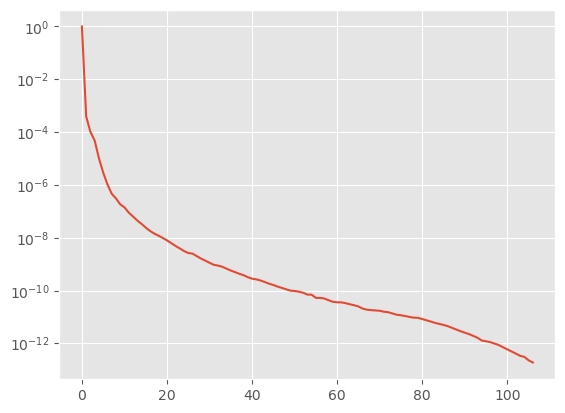

In [20]:
plt.plot([9.99443688e-01, 3.91042971e-04, 1.01769948e-04, 4.78556461e-05,
       1.02071241e-05, 2.93379649e-06, 1.04707583e-06, 4.63394177e-07,
       3.08596492e-07, 1.85006180e-07, 1.41720262e-07, 8.97187465e-08,
       6.39399295e-08, 4.52019224e-08, 3.35719268e-08, 2.42767635e-08,
       1.81212835e-08, 1.44204245e-08, 1.19466814e-08, 9.82692515e-09,
       7.94403208e-09, 6.23379597e-09, 4.90030138e-09, 3.94373622e-09,
       3.13629962e-09, 2.64039562e-09, 2.49734006e-09, 2.01655420e-09,
       1.62316406e-09, 1.35540063e-09, 1.12773813e-09, 9.41748122e-10,
       8.78954296e-10, 7.93996629e-10, 6.73329978e-10, 5.71754053e-10,
       4.99824040e-10, 4.30653112e-10, 3.81042014e-10, 3.20610441e-10,
       2.81351013e-10, 2.65184092e-10, 2.39473148e-10, 2.09667299e-10,
       1.81793157e-10, 1.62354705e-10, 1.41536860e-10, 1.25755554e-10,
       1.11584260e-10, 9.92369825e-11, 9.61007769e-11, 9.05858592e-11,
       8.24506936e-11, 7.02671094e-11, 6.95490247e-11, 5.28218542e-11,
       5.25379078e-11, 4.98451751e-11, 4.29122817e-11, 3.74569702e-11,
       3.58882420e-11, 3.56179323e-11, 3.32279974e-11, 3.02275219e-11,
       2.77165364e-11, 2.49977361e-11, 2.06771319e-11, 1.88482738e-11,
       1.81226430e-11, 1.76649457e-11, 1.71595844e-11, 1.57718857e-11,
       1.51075905e-11, 1.35250120e-11, 1.21611234e-11, 1.15913511e-11,
       1.08107789e-11, 1.00325509e-11, 9.39749601e-12, 9.26287575e-12,
       8.34965357e-12, 7.48425811e-12, 6.71018586e-12, 5.95521903e-12,
       5.44823001e-12, 5.00667896e-12, 4.48483343e-12, 3.87306191e-12,
       3.34713598e-12, 2.89439863e-12, 2.54025674e-12, 2.24920404e-12,
       1.91476691e-12, 1.62354210e-12, 1.28235002e-12, 1.19918884e-12,
       1.11099799e-12, 9.81570772e-13, 8.62239576e-13, 7.11628754e-13,
       5.93063551e-13, 4.93102788e-13, 4.09512266e-13, 3.38311521e-13,
       3.07623409e-13, 2.28795096e-13, 1.88798824e-13])

plt.yscale('log')
plt.show()

Model: AE 



  0%|          | 0/3 [00:00<?, ?it/s]

outputs/visualisation/AE/depth_pre_treatment_pca_n_components_10_norm_on_components_train_on_components/pooling_conv_on_dim_all/channels_[1, 2, 4, 8]/upsample_mode_trilinear/linear_layer_True/cr_10000/1_conv_per_layer/padding_cubic/interp_size_0/final_upsample_upsample/act_fn_Relu/use_final_act_fn_True/lr_0.0001/normalization_mean_std/manage_nan_suppress/n_profiles_None/2025-01-22_13-12/checkpoints/val_loss=0.42-epoch=15.ckpt


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


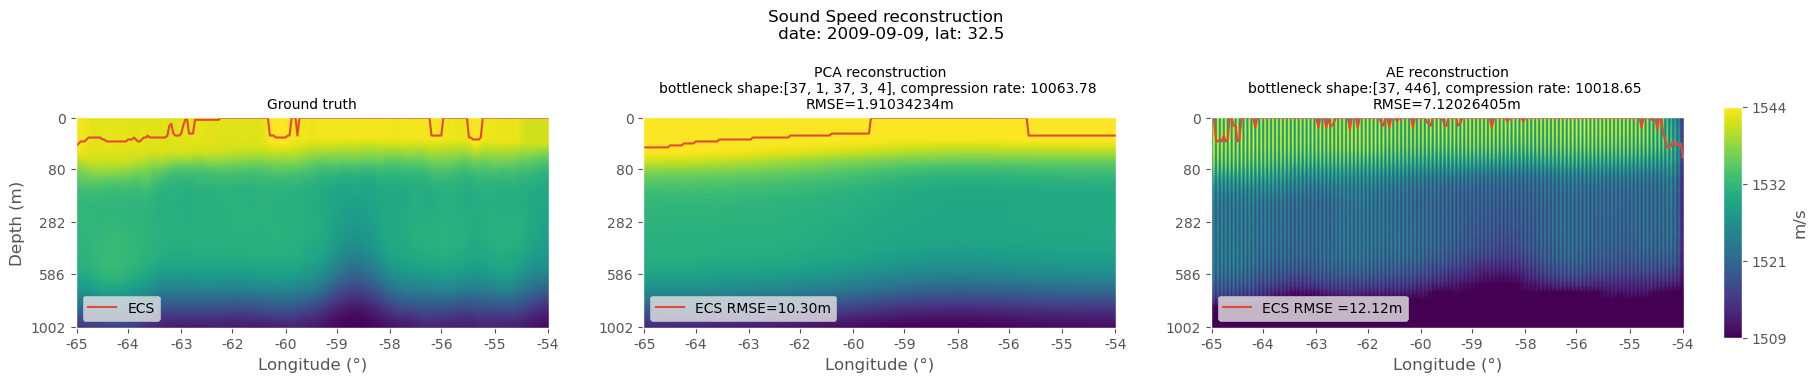

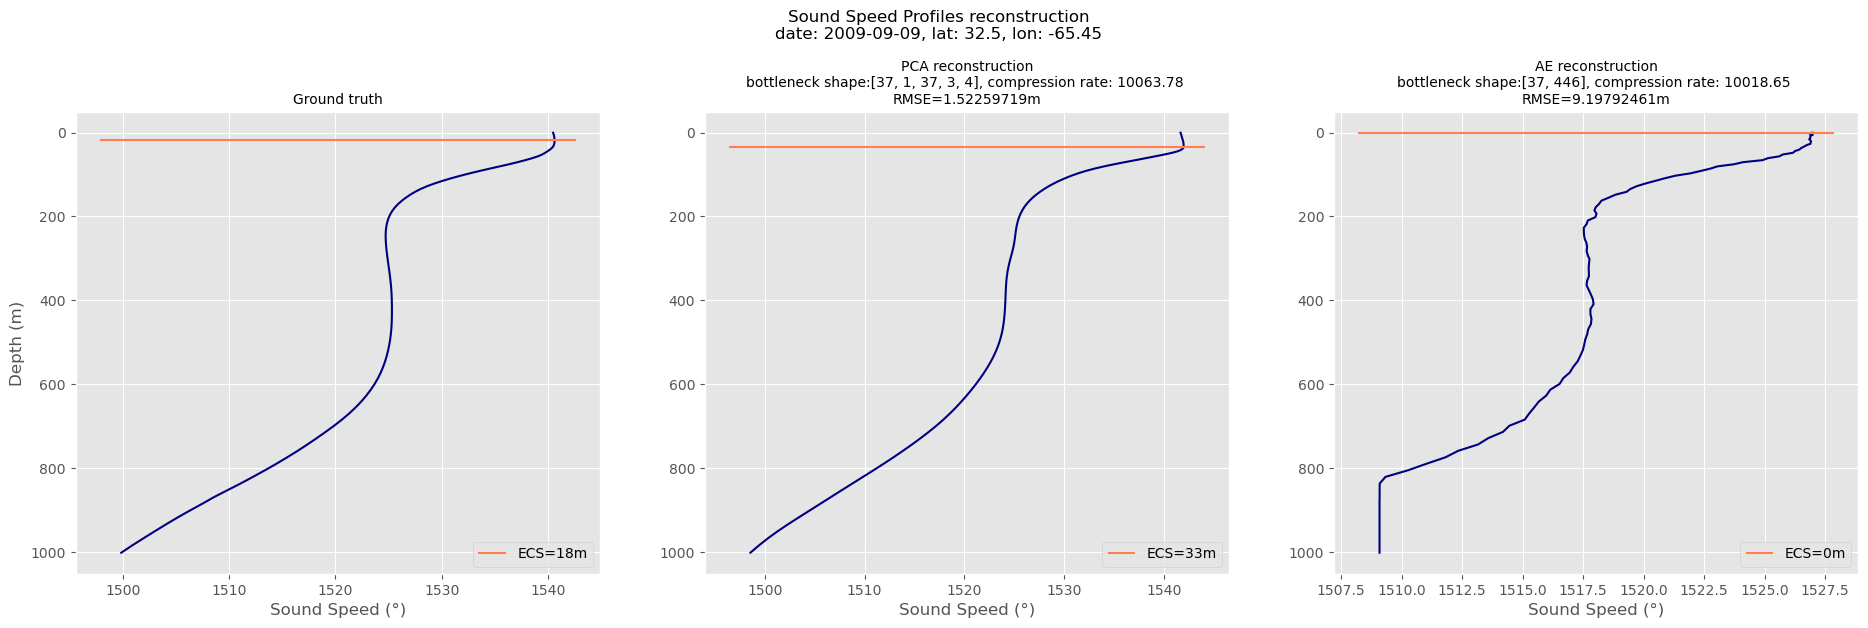

 33%|███▎      | 1/3 [00:04<00:09,  4.74s/it]/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


outputs/visualisation/AE/depth_pre_treatment_pca_n_components_10_norm_on_components_train_on_components/pooling_conv_on_dim_all/channels_[1, 2, 4, 8]/upsample_mode_trilinear/linear_layer_True/cr_100000/1_conv_per_layer/padding_cubic/interp_size_0/final_upsample_upsample/act_fn_Relu/use_final_act_fn_True/lr_0.0001/normalization_mean_std/manage_nan_suppress/n_profiles_None/2025-01-22_13-13/checkpoints/val_loss=0.24-epoch=48.ckpt


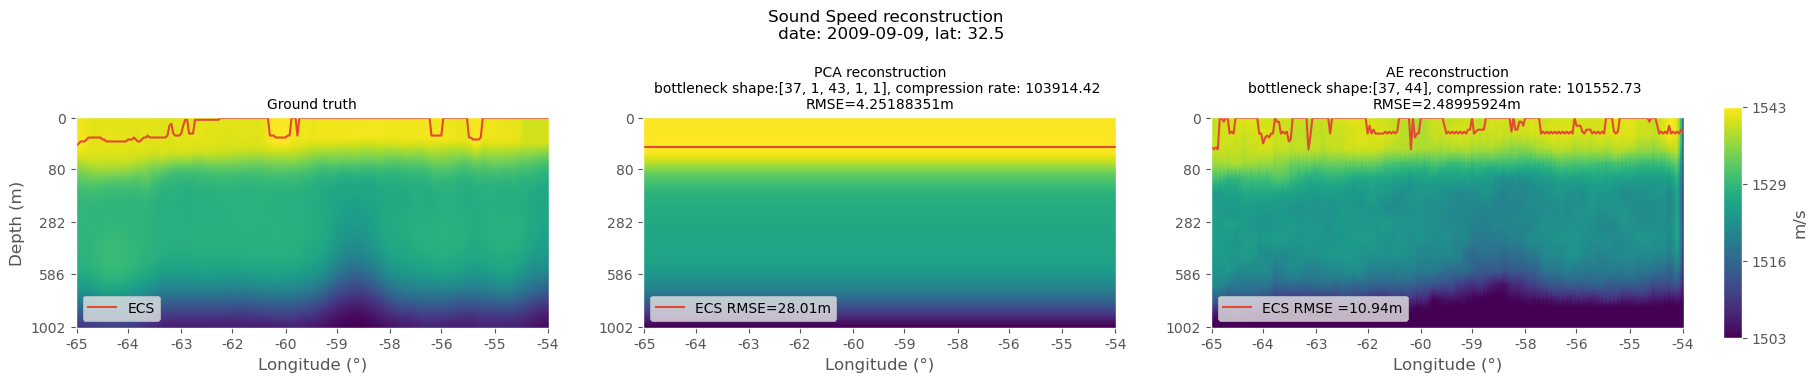

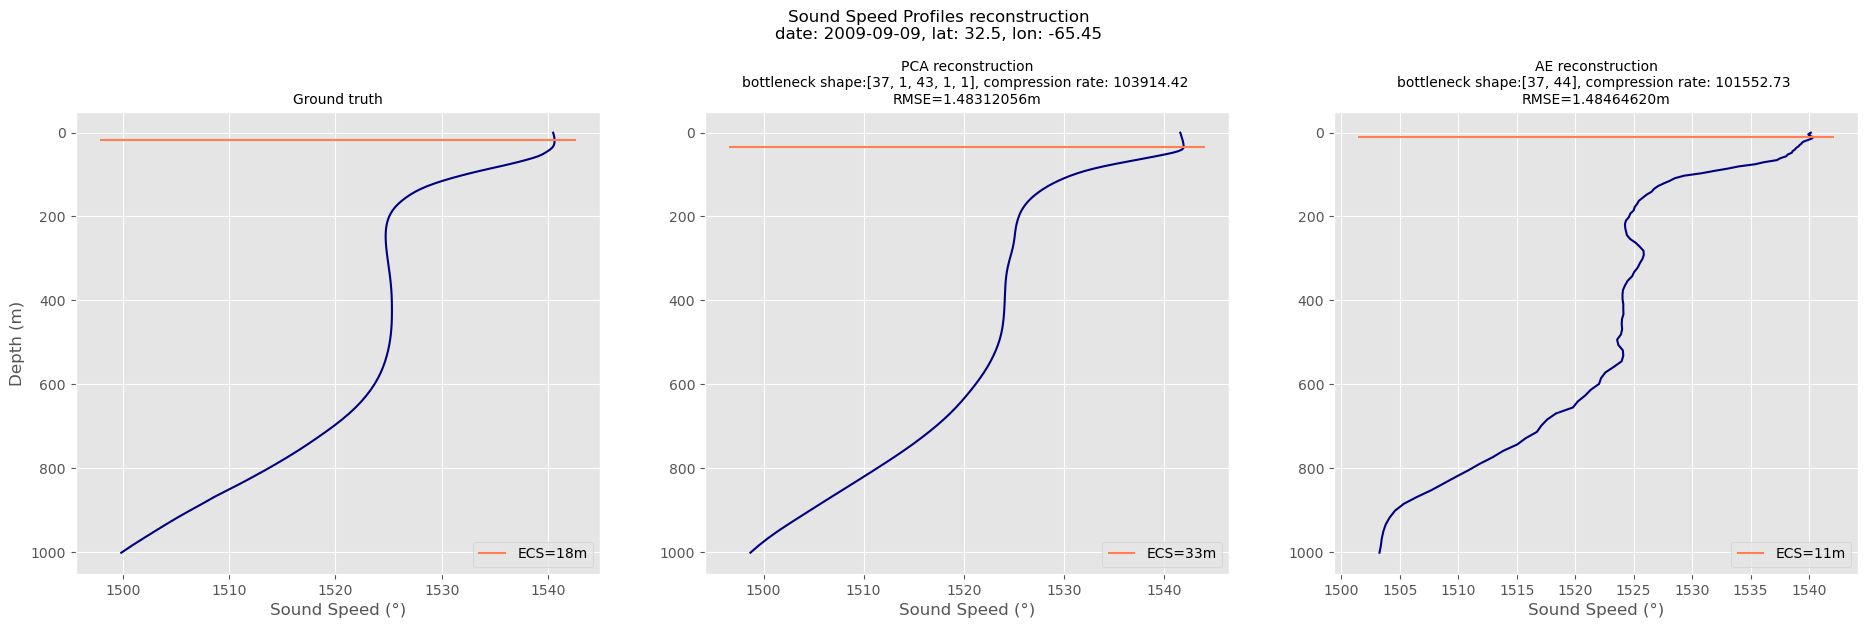

 67%|██████▋   | 2/3 [00:08<00:04,  4.21s/it]

outputs/visualisation/AE/cr 1000/checkpoints/val_loss=0.14-epoch=99.ckpt


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


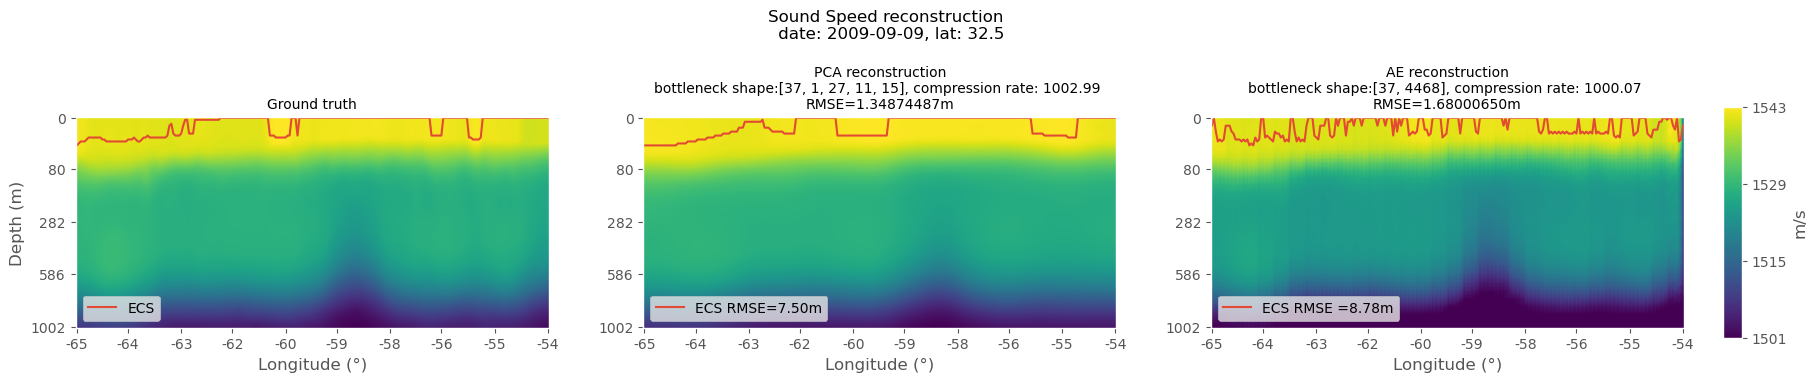

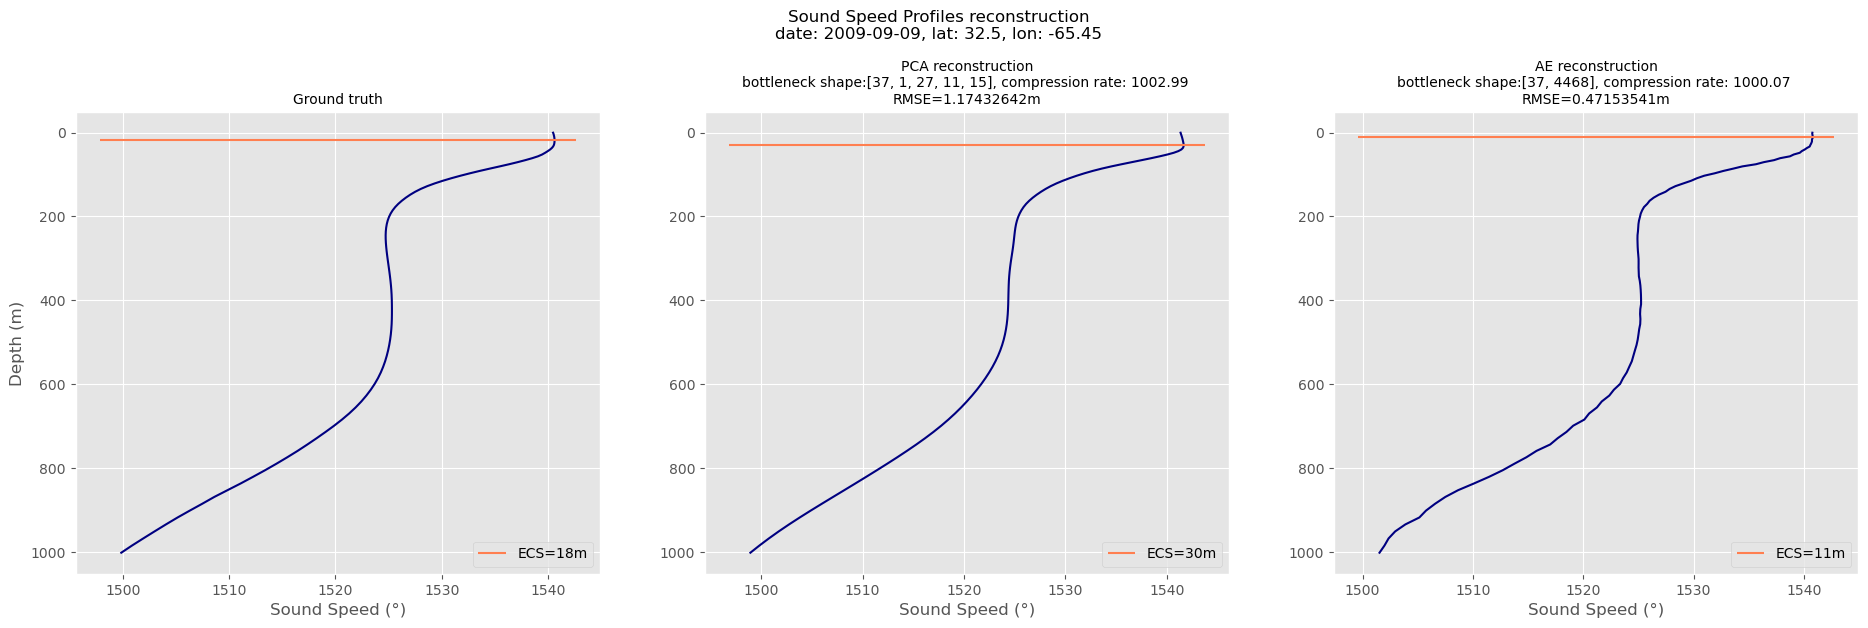

100%|██████████| 3/3 [00:22<00:00,  7.39s/it]


In [33]:
from IPython.display import display, HTML

# t,lat = 9,104
# lon = 90
t,lat,lon = 10,10,10

for model_name in ckpt_dict.keys():

    print(f"Model: {model_name} \n")

    ckpt_list = list(Path(ckpt_dict[model_name]).rglob('*.ckpt'))

    for ckpt_path in tqdm(ckpt_list):
        
        ckpt_path = str(ckpt_path)

        print(ckpt_path)

        try:
            cfg = get_cfg_from_ckpt_path(ckpt_path, pprint = False)        

        except:
            print(f"Can't load config")
            continue
        
        
    
        
        if cfg.datamodule in list(dm_dict.keys()):
            dm = dm_dict[cfg.datamodule]
            test_truth_ssp_arr, dm = loading_datamodule_phase(dm,phase="test")
            test_ssp_truth_tens = torch.tensor(test_truth_ssp_arr, dtype=getattr(torch,cfg.dtype), device=device)



        
        else:

            print("Inititing datamodule; Generating train and test datasets")
            
            dm = hydra.utils.call(cfg.datamodule)  
            test_truth_ssp_arr, dm = loading_datamodule_phase(dm,phase="test")
            test_ssp_truth_tens = torch.tensor(test_truth_ssp_arr, dtype=getattr(torch,cfg.dtype), device=device)
            dm_dict[cfg.datamodule] = dm

            

        
        try:
            lit_model = load_model(ckpt_path, dm, device, verbose = True)    

            # with torch.no_grad():
            #     # Initialize encoder weights and bias for identity function
            #     conv_weights = lit_model.encoder.net[0].weight
            #     conv_weights.fill_(0)
            #     conv_weights[:, :, 3, 3, 3] = 1  # Assuming kernel size is 7x7x7

            #     lit_model.encoder.net[0].bias.fill_(0)

            #     # Initialize decoder weights and bias for identity function
            #     conv_weights = lit_model.decoder.net[0].weight
            #     conv_weights.fill_(0)
            #     conv_weights[:, :, 3, 3, 3] = 1  # Assuming kernel size is 7x7x7

            #     lit_model.decoder.net[0].bias.fill_(0)

        except:
            print("Can't load model ")
            continue

        test_ae_ssp_arr = lit_model(test_ssp_truth_tens).detach().cpu().numpy()
        ae_bottleneck_shape = lit_model.model_AE.bottleneck_shape


        unorm_test_truth_ssp_arr = unorm_ssp_arr_3D(test_truth_ssp_arr,dm)
        unorm_test_ae_ssp_arr = unorm_ssp_arr_3D(test_ae_ssp_arr,dm)
        
        unorm_ssp_shape = unorm_test_truth_ssp_arr.shape
        
        cr = lit_model.model_AE.cr
        n_layer = math.floor(math.log(cr,4))
        spatail_cr = unorm_ssp_shape[2]/math.ceil(unorm_ssp_shape[2]/2**n_layer) * unorm_ssp_shape[3]/math.ceil(unorm_ssp_shape[3]/2**n_layer)
        n_components = int((unorm_ssp_shape[1]*spatail_cr)//cr)
        #n_components = int((unorm_ssp_shape[1]*4**n_layer)//cr)

        if n_components <= 2:
            n_layer = n_layer + 1
            spatail_cr = unorm_ssp_shape[2]/math.ceil(unorm_ssp_shape[2]/2**n_layer) * unorm_ssp_shape[3]/math.ceil(unorm_ssp_shape[3]/2**n_layer)
            n_components = int((unorm_ssp_shape[1]*spatail_cr)//cr)
        

        
        #n_components = min(ae_bottleneck_shape[2],unorm_ssp_shape[1])

        pca = pca_dict[n_components]

            # if cfg.datamodule in list(pca_dict.keys()):
            #     pca = pca_dict[cfg.datamodule]
            # else:
            #     print("Fitting PCA")
            #     train_truth_ssp_arr, dm = loading_datamodule_phase(dm,phase="fit")
            #     train_truth_ssp_arr = unorm_ssp_arr_3D(train_truth_ssp_arr,dm)

            #     pca = PCA(n_components = n_components)
            #     pca.fit(train_truth_ssp_arr.transpose(0,2,3,1).reshape(-1,train_truth_ssp_arr.shape[1]))
            #     pca_dict[cfg.datamodule] = pca


        #unorm_test_pca_ssp_arr = pca.inverse_transform(pca.transform(unorm_test_truth_ssp_arr.transpose(0,2,3,1).reshape(-1,unorm_ssp_shape[1]))).reshape(unorm_ssp_shape[0],unorm_ssp_shape[2],unorm_ssp_shape[3],unorm_ssp_shape[1]).transpose(0,3,1,2)
        
        pca_reduced_test_ssp_tens = torch.tensor(pca.transform(unorm_test_truth_ssp_arr.transpose(0,2,3,1).reshape(-1,unorm_ssp_shape[1])).reshape(unorm_ssp_shape[0],unorm_ssp_shape[2],unorm_ssp_shape[3],n_components).transpose(0,3,1,2), dtype=getattr(torch,cfg.dtype), device=device)


        
        model_pool_pca = NoConvAE(n_layer, pooling_dim="spatial", pooling_mode="Avg")
        pooled_upsampled_pca_test_ssp_tens = model_pool_pca(pca_reduced_test_ssp_tens)

        pca_bottleneck_shape = model_pool_pca.bottleneck_shape

        unorm_test_pca_ssp_arr = pca.inverse_transform(pooled_upsampled_pca_test_ssp_tens.detach().cpu().numpy().transpose(0,2,3,1).reshape(-1,n_components)).reshape(unorm_ssp_shape[0],unorm_ssp_shape[2],unorm_ssp_shape[3],unorm_ssp_shape[1]).transpose(0,3,1,2)


        bottleneck_shape_tuple = (ae_bottleneck_shape,pca_bottleneck_shape)

        
        ##worst ssp
        ssp_mse = np.mean((unorm_test_truth_ssp_arr-unorm_test_ae_ssp_arr)**2,axis=(1,3))
        rmse_ssp_lat_lon = np.sqrt(np.mean((unorm_test_truth_ssp_arr-unorm_test_ae_ssp_arr)**2,axis=(0,1)))

        t_max_ssp, lat_max_ssp = np.unravel_index(np.argmax(ssp_mse), ssp_mse.shape)

        lon_max_ssp = np.argmax(np.mean((unorm_test_truth_ssp_arr[t_max_ssp,:,lat_max_ssp,:]-unorm_test_ae_ssp_arr[t_max_ssp,:,lat_max_ssp,:])**2,axis = 0))


        ecs_truth = dm.depth_array[np.argmax(unorm_test_truth_ssp_arr,axis=1)]
        ecs_pred = dm.depth_array[np.argmax(unorm_test_ae_ssp_arr,axis=1)]
        rmse_lat_lon = np.sqrt(np.mean((unorm_test_truth_ssp_arr-unorm_test_ae_ssp_arr)**2,axis=(0,1)))


        ecs_mse = np.mean((ecs_truth-ecs_pred)**2,axis=(2))
        rmse_ecs_lat_lon = np.sqrt(np.mean((ecs_truth-ecs_pred)**2,axis=(0)))


        t_max_ecs, lat_max_ecs = np.unravel_index(np.argmax(ecs_mse), ecs_mse.shape)
        lon_max_ecs = np.argmax((ecs_truth[t_max_ecs, lat_max_ecs,:]-ecs_pred[t_max_ecs, lat_max_ecs,:])**2)






        plot_unorm_ssp_2D(unorm_test_truth_ssp_arr,
                        unorm_test_pca_ssp_arr,
                        unorm_test_ae_ssp_arr, 
                        dm,
                        bottleneck_shape_tuple,
                        t,
                        lat)


        plot_unorm_ssp_profiles(unorm_test_truth_ssp_arr,
                                unorm_test_pca_ssp_arr,
                                unorm_test_ae_ssp_arr, 
                                dm,
                                bottleneck_shape_tuple,
                                t,
                                lat,
                                lon)
        
        plt.show()
        
        # display(HTML(f"<span style='font-size:20px;'>Worst SSP reconstruction: t_max_ssp: {t_max_ssp}, lat_max_ssp: {lat_max_ssp}, lon_max_ssp: {lon_max_ssp}</span>"))

        # plot_unorm_ssp_2D(unorm_test_truth_ssp_arr,
        #                 unorm_test_pca_ssp_arr,
        #                 unorm_test_ae_ssp_arr, 
        #                 dm,
        #                 bottleneck_shape_tuple,
        #                 t_max_ssp,
        #                 lat_max_ssp)


        # plot_unorm_ssp_profiles(unorm_test_truth_ssp_arr,
        #                         unorm_test_pca_ssp_arr,
        #                         unorm_test_ae_ssp_arr, 
        #                         dm,
        #                         bottleneck_shape_tuple,
        #                         t_max_ssp,
        #                         lat_max_ssp,
        #                         lon_max_ssp)
        # #Plot RMSE with a red and white colormap
        # plt.figure(figsize=(10, 5))
        # plt.imshow(rmse_ssp_lat_lon, origin='lower', aspect='auto', extent=[dm.test_ds.input.coords["lon"].values.min(), dm.test_ds.input.coords["lon"].values.max(), dm.test_ds.input.coords["lat"].values.min(), dm.test_ds.input.coords["lat"].values.max()], cmap='Reds')
        # plt.colorbar(label='RMSE (m/s)')
        # plt.clim(0, 20)
        # plt.xticks(ticks=np.arange(np.ceil(min(dm.test_ds.input.coords["lon"].values)), np.ceil(max(dm.test_ds.input.coords["lon"].values)), 1))
        # plt.yticks(ticks=np.arange(np.ceil(min(dm.test_ds.input.coords["lat"].values)), np.ceil(max(dm.test_ds.input.coords["lat"].values)), 1))
        # plt.xlabel('Longitude')
        # plt.ylabel('Latitude')
        # plt.title('RMSE over SSP across Latitude and Longitude')
        # plt.grid(False)
        # plt.show()
        
        
        # display(HTML(f"<span style='font-size:20px;'>Worst ECS reconstruction: t_max_ssp: {t_max_ecs}, lat_max_ssp: {lat_max_ecs}, lon_max_ssp: {lon_max_ecs}</span>"))

        # plot_unorm_ssp_2D(unorm_test_truth_ssp_arr,
        #         unorm_test_pca_ssp_arr,
        #         unorm_test_ae_ssp_arr, 
        #         dm,
        #         bottleneck_shape_tuple,
        #         t_max_ecs,
        #         lat_max_ecs)


        # plot_unorm_ssp_profiles(unorm_test_truth_ssp_arr,
        #                         unorm_test_pca_ssp_arr,
        #                         unorm_test_ae_ssp_arr, 
        #                         dm,
        #                         bottleneck_shape_tuple,
        #                         t_max_ecs,
        #                         lat_max_ecs,
        #                         lon_max_ecs)
        

        # plt.figure(figsize=(10, 5))
        # plt.imshow(rmse_ecs_lat_lon, origin='lower', aspect='auto', extent=[dm.test_ds.input.coords["lon"].values.min(), dm.test_ds.input.coords["lon"].values.max(), dm.test_ds.input.coords["lat"].values.min(), dm.test_ds.input.coords["lat"].values.max()], cmap='Reds')
        # plt.colorbar(label='RMSE (m)')
        # plt.clim(0, 250)
        # plt.xticks(ticks=np.arange(np.ceil(min(dm.test_ds.input.coords["lon"].values)), np.ceil(max(dm.test_ds.input.coords["lon"].values)), 1))
        # plt.yticks(ticks=np.arange(np.ceil(min(dm.test_ds.input.coords["lat"].values)), np.ceil(max(dm.test_ds.input.coords["lat"].values)), 1))
        # plt.xlabel('Longitude')
        # plt.ylabel('Latitude')
        # plt.title('RMSE over ECS across Latitude and Longitude')
        # plt.grid(False)


        
        # plt.show()


# Indexes for max error

## Error on ssp

In [22]:
# projection = ccrs.PlateCarree()
# ax = plt.axes(projection = ccrs.PlateCarree())
# ax.set_extent([np.ceil(min(dm.test_ds.input.coords["lon"].values)), np.floor(max(dm.test_ds.input.coords["lon"].values)), np.ceil(min(dm.test_ds.input.coords["lat"].values)), np.floor(max(dm.test_ds.input.coords["lat"].values))])
# #ax.set_extent([-80, -45, 15, 55])
# ax.coastlines()

# rmse_lat_lon = np.sqrt(np.mean((unorm_test_truth_ssp_arr-unorm_test_ae_ssp_arr)**2,axis=(0,1)))
# plt.imshow(rmse_lat_lon, origin='lower', aspect='auto', extent=[dm.test_ds.input.coords["lon"].values.min(), dm.test_ds.input.coords["lon"].values.max(), dm.test_ds.input.coords["lat"].values.min(), dm.test_ds.input.coords["lat"].values.max()])
# plt.colorbar(label='RMSE')
# plt.xticks(ticks=np.arange(np.ceil(min(dm.test_ds.input.coords["lon"].values)), np.ceil(max(dm.test_ds.input.coords["lon"].values)), 1))
# plt.yticks(ticks=np.arange(np.ceil(min(dm.test_ds.input.coords["lat"].values)), np.ceil(max(dm.test_ds.input.coords["lat"].values)), 1))
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('RMSE across Latitude and Longitude')
# plt.grid(False)
# plt.show()